In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline,make_pipeline
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import spacy
import tensorflow as tf
import gensim
from gensim.models import Word2Vec
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.decomposition import LatentDirichletAllocation
import gensim.corpora as corpora
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import random
from sklearn.decomposition import NMF
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Embedding,Dense,Flatten, Input, GlobalMaxPooling1D,MaxPooling1D,Dropout,Activation,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

# Text data

# Working with NLTK

In [ ]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df.head()

In [ ]:
df.shape # 7613 observations and four features and one target

In [ ]:
sns.countplot(data=df,x='target')

In [ ]:
df['target'].value_counts()

In [ ]:
df['target'] = df.target.astype(str)
df.dtypes 

### Features and Labels

In [ ]:
data = df[['text','target']]
data.head()

In [ ]:
# any null columns
data.isnull().sum()

In [ ]:
# remove all characters not number or characters
def cleanText(input_string):
    modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
    modified_string = re.sub('[0-9]+', ' ', modified_string)
    modified_string=re.sub("[@]","",modified_string)
    return(modified_string)
data['text'] = data.text.apply(cleanText)
data['text'][150]



In [ ]:
# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text
data['text'] = data.text.apply(remove_not_ASCII)
data['text'][150]


In [ ]:
data.sample(10)

In [ ]:
#converting to lower case
data['text']=data['text'].str.lower()

In [ ]:
#removing punctuations
data['text']=data['text'].str.translate(str.maketrans('','',string.punctuation))

In [ ]:
 nltk.download('stopwords')

In [ ]:
stopWords=stopwords.words('english')+['the', 'a', 'k','h','g','an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'n','from','u','w','p','x','c','r','co','http','https','b','e','v','l','q']
def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
    return newtxt
data['text'] = [removeStopWords(stopWords,x) for x in data['text']]

In [ ]:
#removing hyperlink
data['text']=data['text'].apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )

In [ ]:
#remove words containing numbers
data['text']=data['text'].apply(lambda x:re.sub('\w*\d\w*' , '', x) )

In [ ]:
#removing square brackets
data['text']=data['text'].apply(lambda x:re.sub('\[.*?\]', '', x) )
data['text']=data['text'].apply(lambda x:re.sub('<.*?>+', '', x) )

In [ ]:
#splitting text into words
tokenList=[]
for indx in range(len(data)):
       token=word_tokenize(data['text'][indx])
       tokenList.append(token)
data['text_tokens'] = tokenList
data.head()

## Frequency distributions

In [ ]:
textcorpus=' ' .join([str(item) for item in data['text_tokens'] ])

In [ ]:
#textcorpus

In [ ]:
word_tokens = word_tokenize(textcorpus)

#print(word_tokens)

In [ ]:
#removing punctuations
filtered_words = []

for w in word_tokens:
    if w not in string.punctuation:
        filtered_words.append(w)
        
#print(filtered_words)

In [ ]:
freq_dist = FreqDist(filtered_words)

print(freq_dist)

In [ ]:
freq_dist.most_common(20)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

freq_dist.plot(20, cumulative=False)

plt.show()

#### We can view the most frequent terms in the word cloud

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(textcorpus)
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
text = data.text[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(data.target[0]) ## disaster tweet

### When target equals 1 

In [ ]:
df_1 = data[data.target == '1']

In [ ]:
df_1.head()

In [ ]:
text = " ".join(x for x in df_1.text)


In [ ]:
len(text)

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### when target equals 0

In [ ]:
df_0 = data[data.target == '0']

In [ ]:
text = " ".join(x for x in df_0.text)
len(text)

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Extracting Features from Text
##### Using Bag of Words, TF-IDF Transformation

#### Use CountVectorizer to convert a collection of text documents to a "bag of words"

In [ ]:
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df['text'])

bag_of_words

In [ ]:
print(bag_of_words)

#### Get the value to which a word is mapped

In [ ]:
vectorizer.vocabulary_.get('disaster')

In [ ]:
#vectorizer.vocabulary_

In [ ]:
#pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names())

#### Extend bag of words with TF-IDF weights

In [ ]:
vectorizer = TfidfVectorizer()
bag_of_words = vectorizer.fit_transform(df['text'])

print(bag_of_words)

# Analysis #1 NLTK and BoW model and Text Classification

In [ ]:
y = data['target']
X = data['text']

### Train Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Tfidf Vectorization

In [ ]:

tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
tfidf.fit(X_train)

In [ ]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf

In [ ]:
X_test_tfidf

In [ ]:
#X_test

### Model training

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)

In [ ]:
log = LogisticRegression(max_iter=500)
log.fit(X_train_tfidf,y_train)

In [ ]:
svc = LinearSVC(penalty="l2")
svc.fit(X_train_tfidf,y_train)

### Evaluation

### Naive Bayes

In [ ]:
preds = nb.predict(X_test_tfidf)
predicted_prob = nb.predict_proba(X_test_tfidf)
print(classification_report(y_test,preds))

In [ ]:
confusion_matrix(y_test,preds)

In [ ]:
classes = np.unique(y_test)

In [ ]:
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

### Logistic Regression

In [ ]:
preds = log.predict(X_test_tfidf)
print(classification_report(y_test,preds))
confusion_matrix(y_test,preds)


In [ ]:
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

### Support Vector Machine

In [ ]:
preds = svc.predict(X_test_tfidf)
print(classification_report(y_test,preds))
confusion_matrix(y_test,preds)

In [ ]:
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

### Logistic Regression and Naive Bayes do have the same accuracy but differs slightly in the precision and recall

### Test data

In [ ]:
dftest = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
dftest.head()

In [ ]:
X = dftest[['text']]
X.head()

### Applying the same transformation on the test data as on the train data

In [ ]:
X = X.text.apply(cleanText)
X[150]

In [ ]:
#converting to lower case
X = X.str.lower()

In [ ]:
#removing punctuations
X=X.str.translate(str.maketrans('','',string.punctuation))

In [ ]:
X = [removeStopWords(stopWords,x) for x in X]

In [ ]:
X_test = tfidf.transform(X)

In [ ]:
X_test

In [ ]:
preds = nb.predict(X_test)


In [ ]:
preds

In [ ]:
X_test.shape

In [ ]:
len(preds)

In [ ]:
len(dftest)

In [ ]:
df_submission = pd.DataFrame({'id': dftest.id, 'target' : preds} )
df_submission.head()
df_submission.to_csv('/kaggle/working/submission.csv', index=False) #0.79619


# Analysis #2 Understanding Spacy

In [ ]:

nlp = spacy.load("en_core_web_sm")

doc = nlp(data["text"].values[1])
print(doc)

for entity in doc.ents:
    print(entity.text, entity.label_)

#### Entities

In [ ]:
doc.ents

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

data["ents"] = data["text"].progress_map(lambda text: [(entity.text, entity.label_) for entity in nlp(text).ents])

In [ ]:
data.sample(5)

In [ ]:
data["ent_types"] = data["ents"].progress_map(lambda x: set(ent[1] for ent in x))

In [ ]:
def replace_text(text, entities):
    for ent_name, ent_type in entities:
        text = text.replace(ent_name, ent_type)
        
    return text

data["format_text"] = data.progress_apply(lambda x: replace_text(x["text"], x["ents"]), axis=1)

In [ ]:
data.sample(5)

In [ ]:
train_df, test_df = train_test_split(data, stratify=data["target"], test_size=0.1)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, 
                                min_df=5,
                                lowercase=True,
                                stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df["format_text"].values)

In [ ]:
train_tfidf

In [ ]:
model = LogisticRegression(multi_class="multinomial")
model.fit(train_tfidf, train_df["target"])

In [ ]:
test_tfidf = tfidf_vectorizer.transform(test_df["format_text"])
test_preds = model.predict(test_tfidf)
accuracy_score(test_df["target"], test_preds)

In [ ]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize

ps = PorterStemmer() 
def stem_sentence(text):
    return " ".join([ps.stem(word) for word in word_tokenize(text)])

train_df["processed_text"] = train_df["format_text"].progress_map(stem_sentence)
test_df["processed_text"] = test_df["format_text"].map(stem_sentence)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, 
                                min_df=5,
                                lowercase=True,
                                stop_words='english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df["processed_text"].values)

In [ ]:
model = LogisticRegression(multi_class="multinomial")
model.fit(train_tfidf, train_df["target"])

test_tfidf = tfidf_vectorizer.transform(test_df["processed_text"])
test_preds = model.predict(test_tfidf)
accuracy_score(test_df["target"], test_preds)

In [ ]:
train_tfidf

# BoW model Ngrams

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, 
                                   min_df=5,
                                   lowercase=True,
                                   stop_words='english',
                                   ngram_range=(1, 2) 
                                  )
train_tfidf = tfidf_vectorizer.fit_transform(train_df["processed_text"].values)

train_tfidf.shape

In [ ]:
model = LogisticRegression(solver='sag',multi_class="multinomial")
model.fit(train_tfidf, train_df["target"])



In [ ]:
test_tfidf = tfidf_vectorizer.transform(test_df["processed_text"])
test_preds = model.predict(test_tfidf)
accuracy_score(test_df["target"], test_preds)

In [ ]:
data['text length'] = data['text'].apply(len)

In [ ]:
g = sns.FacetGrid(data,col='target')
g.map(plt.hist,'text length')

In [ ]:
sns.boxplot(x='target',y='text length',data=data,palette='rainbow')

In [ ]:
X=data['text']
y=data['target']

In [ ]:

cv = CountVectorizer()

In [ ]:
X = cv.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [ ]:
nb = MultinomialNB()

In [ ]:
nb.fit(X_train,y_train)

In [ ]:
predictions = nb.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

# Pipeline

In [ ]:

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
X = data['text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [ ]:
pipeline.fit(X_train,y_train)

In [ ]:
predictions = pipeline.predict(X_test)

In [ ]:
predicted_prob = pipeline.predict_proba(X_test)

In [ ]:
predicted_prob

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

In [ ]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

# Interpreting text predictions with LIME

In [ ]:
## select observation
idx = 0
txt_instance = X_test.iloc[idx]
## check true value and predicted value
print("True:", y_test.iloc[idx], "--> Pred:", predictions[idx], "| Prob:", round(np.max(predicted_prob[idx]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, pipeline.predict_proba, num_features=6)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

In [ ]:
## select observation
idx = 1
txt_instance = X_test.iloc[idx]
print(txt_instance)
## check true value and predicted value
print("True:", y_test.iloc[idx], "--> Pred:", predictions[idx], "| Prob:", round(np.max(predicted_prob[idx]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, pipeline.predict_proba, num_features=6)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

In [ ]:
## select observation
idx = 2
txt_instance = X_test.iloc[idx]
print(txt_instance)
## check true value and predicted value
print("True:", y_test.iloc[idx], "--> Pred:", predictions[idx], "| Prob:", round(np.max(predicted_prob[idx]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, pipeline.predict_proba, num_features=6)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

In [ ]:
## select observation
idx = 3
txt_instance = X_test.iloc[idx]
print(txt_instance)
## check true value and predicted value
print("True:", y_test.iloc[idx], "--> Pred:", predictions[idx], "| Prob:", round(np.max(predicted_prob[idx]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, pipeline.predict_proba, num_features=6)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

In [ ]:
## select observation
idx = 4
txt_instance = X_test.iloc[idx]
print(txt_instance)
## check true value and predicted value
print("True:", y_test.iloc[idx], "--> Pred:", predictions[idx], "| Prob:", round(np.max(predicted_prob[idx]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, pipeline.predict_proba, num_features=6)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

In [ ]:
X = dftest['text']

In [ ]:
predictions = pipeline.predict(X)

In [ ]:
df_submission = pd.DataFrame({'id': dftest.id, 'target' : predictions} )

In [ ]:
df_submission.head()

In [ ]:
#df_submission.to_csv('/kaggle/working/submissionnew2.csv', index=False)  ## 0.79007 accuracy

# Analysis#3 Understanding Word Embeddings with Gensim 

#### Word2vec learns the meaning of words by processing a large corpus of unlabelled text. The word embeddings are the weights of the hidden layer that the neural network learns during the training process.The Word2vec model contains information about the relationships between words including similarity. The two ways of training word2vec embeddings are the skip gram approach that predicts the output words from a word of interest and continuous bag of words model predicts the target word from the nearby words.

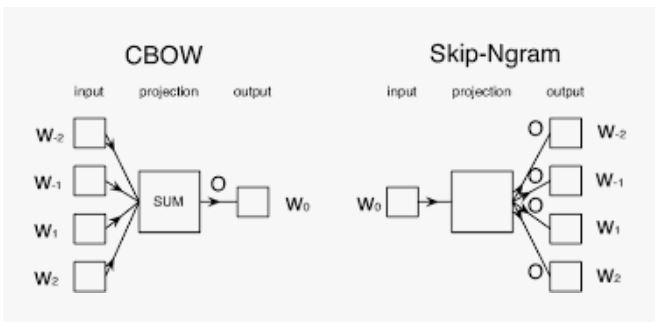

#### we can either use pre trained model or train word2vec from the text corpus

In [ ]:
# take the text column
text = data['text'].values
text

In [ ]:
# tokenize the words
new_vec = [nltk.word_tokenize(textdata) for textdata in text]
new_vec[0]

In [ ]:
# build the model
model = Word2Vec(new_vec, min_count=1,vector_size=32)
model

In [ ]:
# predict the output
model.wv.most_similar('fire')
model.wv['fire']

In [ ]:
vec = model.wv['disaster']
model.wv.most_similar([vec]) #### fire, emergency similar to disaster

In [ ]:
vec = model.wv['police']
model.wv.most_similar([vec]) #### people, fire similar to police

In [ ]:
vec = model.wv['emergency']
model.wv.most_similar([vec]) #### crash, fire similar to emergency

# Analysis#4

# Topic modelling with Latent Dirichlet Allocation

#### Documents are probability distributions over topics and topics themselves are the probability distribution over words

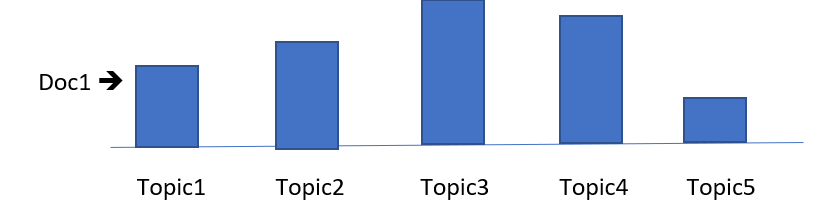

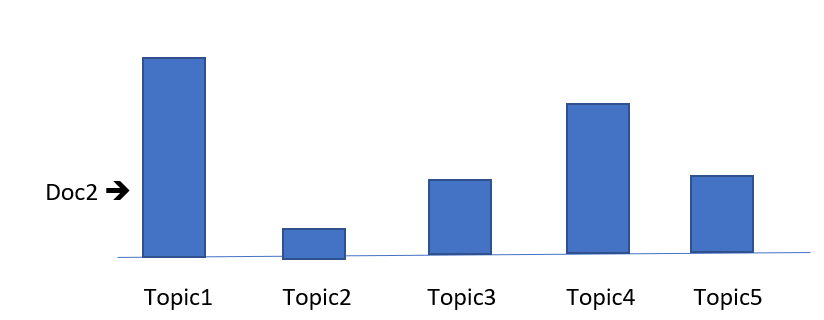

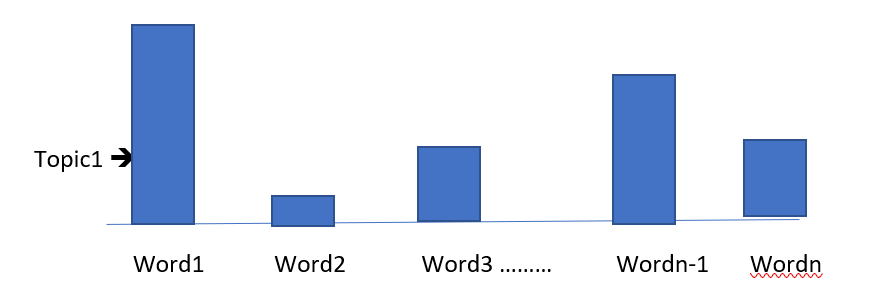

#### disaster tweets and non disaster tweets

In [ ]:
disaster_tweets_df = data[data['target']=="1"]['text']
nondisaster_tweets_df = data[data['target']=="0"]['text']

In [ ]:
LDA = LatentDirichletAllocation(n_components=4,random_state=42) # 4 topics

In [ ]:
vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(disaster_tweets_df)
dtm

In [ ]:
LDA.fit(dtm)

In [ ]:
len(vectorizer.get_feature_names())

#### lets check random 10 stored words

In [ ]:


for i in range(10):
    random_id = random.randint(0,len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[random_id])

In [ ]:
for i in range(10):
    random_id = random.randint(0,len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[random_id])

#### Words per topic

In [ ]:
LDA.components_

In [ ]:
len(LDA.components_[0])

In [ ]:
single_topic = LDA.components_[0]

In [ ]:
# Returns the indices that would sort this array.
single_topic.argsort()

In [ ]:
top_word_indices = single_topic.argsort()[-10:]

#### The first topic contains the probabilities of words for topic 1. 
#### To sort the indexes according to probability values, we use the argsort() function. 
#### Once sorted, the 10 words with the highest probabilities will now belong to the last 10 indexes of the array.

In [ ]:
for index in top_word_indices:
    print(vectorizer.get_feature_names()[index]) # we can find words like bomber, suicide, oil, spill, fire, sandstorm

In [ ]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 15 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#### non disaster tweets 

In [ ]:
dtm = vectorizer.fit_transform(nondisaster_tweets_df)
dtm

In [ ]:
LDA.fit(dtm) # 4 topics

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
for i in range(10):
    random_id = random.randint(0,len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[random_id])


In [ ]:
for i in range(10):
    random_id = random.randint(0,len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[random_id])


#### words per topic

In [ ]:
LDA.components_

In [ ]:
len(LDA.components_[0])

In [ ]:
single_topic = LDA.components_[0]

In [ ]:
# Returns the indices that would sort this array.
single_topic.argsort()

In [ ]:
# Top 10 words for this topic:
single_topic.argsort()[-10:]

In [ ]:
top_word_indices = single_topic.argsort()[-10:]

In [ ]:
for index in top_word_indices:
    print(vectorizer.get_feature_names()[index])

In [ ]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 15 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#### LDA with gensim
#### The Dictionary and Corpus needed for Topic Modeling
#### The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

In [ ]:
disaster_tweets_df = data[data['target']=="1"]['text_tokens']

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(disaster_tweets_df.values)

In [ ]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in disaster_tweets_df]

# View
print(corpus[:1])

In [ ]:
id2word[0]

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

#### alpha and eta are hyperparameters that affect sparsity of the topics.


#### chunksize is the number of documents to be used in each training chunk. 
#### update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### The above LDA model is built with 4 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#### Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

#### Topic1 and Topic4 related to nature related catastrophe for example weather, tornado, volcano, thunderstorm, storm, weather, wiildfire.
#### Topic2 army, crash, bombing, survivors
#### Topic3 migrants, trauma, earthquake, shots

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

#### non disaster tweets

In [ ]:

nondisaster_tweets_df = data[data['target']=="0"]['text_tokens']

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(nondisaster_tweets_df.values)


In [ ]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in nondisaster_tweets_df]

# View
print(corpus[:1])

In [ ]:
id2word[0]

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#### Topic1 words like survive,disney,love,pretty
#### Topic2 words like youtube, videos, amazon, work
#### Topic3 words like good, movie, school, emotional
#### Topic4 words like stock, new, great, god

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

#### how non-negative matrix factorization can be used for topic modeling.

#### Non-negative matrix factorization is also a supervised learning technique which performs clustering as well as dimensionality reduction. It can be used in combination with TF-IDF scheme to perform topic modeling.

#### disaster tweets

In [ ]:
disaster_tweets_df = data[data['target']=="1"]['text']

In [ ]:
vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(disaster_tweets_df)
dtm

In [ ]:


nmf = NMF(n_components=4, random_state=42)
nmf.fit(dtm )

In [ ]:
for i in range(10):
    random_id = random.randint(0,len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[random_id])

In [ ]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [ ]:
for i in top_topic_words:
    print(vectorizer.get_feature_names()[i])

In [ ]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 15 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#### non disaster tweets

In [ ]:
nondisaster_tweets_df = data[data['target']=="0"]['text']

In [ ]:
vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(nondisaster_tweets_df)
dtm

In [ ]:
nmf = NMF(n_components=4, random_state=42)
nmf.fit(dtm )

In [ ]:
for i in range(10):
    random_id = random.randint(0,len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[random_id])

In [ ]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [ ]:
for i in top_topic_words:
    print(vectorizer.get_feature_names()[i])

In [ ]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 15 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

# Analysis#5

# CNN1D for Text Classification


In [ ]:
y = data['target']
X = data['text']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [ ]:
# Model constants.
max_features = 200000
embedding_dim = 128

In [ ]:
tokenizer = Tokenizer(num_words=5000)

In [ ]:
print(X_train[2])

In [ ]:
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
vocab_size

In [ ]:
print(X_train[2])

In [ ]:
for word in ['residents', 'shelter', 'place', 'evacuation','expected','notified']:
     print('{}: {}'.format(word, tokenizer.word_index[word]))

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

A maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

In [ ]:
maxlen = 24

#### every text is of length 24

In [ ]:
 X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

In [ ]:
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
print(X_train[0, :])

the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. Will need the following parameters:

input_dim: the size of the vocabulary output_dim: the size of the dense vector input_length: the length of the sequence

In [ ]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [ ]:
#embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(32, 4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
preds = model.predict(X_test)

In [ ]:
preds=tf.squeeze(tf.round(preds))

In [ ]:
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))